## Compare our classifier to other SL classifiers

Comparisons to three other SL classifiers:
* SINaTRA (Jacunski et al. 2015): https://doi.org/10.1371/journal.pcbi.1004506  
* SLant (Benstead-Hume et al. 2019): https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006888   
* Dual-DropoutGCN (Cai et al. 2020): https://doi.org/10.1093/bioinformatics/btaa211 / https://github.com/CXX1113/Dual-DropoutGCN

**Output**: Table S7: ROC AUC and avg. precision values for four test datasets for the three other classifiers and ours

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import os
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_features = get_local_data_path([], 'feature_list.txt')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')
file_all_pairs = get_local_data_path(['processed','ensembl93'], 'all_pairs.csv')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')
file_all_screened_pairs = get_local_data_path(['processed', 'screen_pairs'], 'all_screened_pairs.csv')

# Predictions from other classifiers
file_sinatra_preds = lambda n: get_data_path(['sinatra'], 'JacunskiEtAl_SINaTRA_Human_Filtered_Predictions_'+str(n)+'.txt.gz')
# From Graeme - full, un-filtered version of the predictions file that is in the Slorth DB
file_slant_full = get_data_path(['SLant'], 'human_predictions.csv')
file_cai_pred = get_data_path(['cai_2020'], 'case_study_k=all.csv')
file_cai_training = get_data_path(['cai_2020'], 'SL_Human_Approved.txt')

# Output
file_table_s7 = get_local_data_path(['supplemental_files'], 'Table_S7.xlsx')

### Load data + our RF model

In [2]:
paralog_annot = pd.read_csv(file_annot_pairs)
print('Num annotated pairs:', paralog_annot.shape[0])
paralog_annot[:1]

Num annotated pairs: 36648


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_cerevisiae_ortholog_ip,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG_OSCAR,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,...,False,False,False,False,False,False,3,210.95,0.0,False


In [18]:
all_pairs = pd.read_csv(file_all_pairs)
all_pairs.insert(0, 'sorted_gene_pair', all_pairs.apply(lambda x: '_'.join(sorted([x.A1,x.A2])), axis=1))
print('N:', all_pairs.shape[0])
all_pairs[:1]

N: 73296


,sorted_gene_pair,A1_ensembl,A2_ensembl,sequence_identity,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id,cds_length_ratio,A1,A1_entrez,A2,A2_entrez
0,TEKT2_TEKT4,ENSG00000092850,ENSG00000163060,0.293023,0.289655,0.293023,False,True,True,False,False,5,0,0.988532,TEKT2,27285,TEKT4,150483


In [4]:
features = pd.read_csv(file_features).feature.values.tolist()
print('N features:', len(features))

N features: 22


In [5]:
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

In [6]:
depmap_pairs = pd.read_csv(file_depmap_pairs)
depmap_pairs = pd.merge(depmap_pairs, paralog_annot)
print('N SL:', sum(depmap_pairs.SL), '/', depmap_pairs.shape[0])
depmap_pairs[:1]

N SL: 126 / 3634


,sorted_gene_pair,SL,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,...,has_cerevisiae_ortholog_ip,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,AAK1_BMP2K,False,AAK1,BMP2K,ENSG00000115977,ENSG00000138756,22848,55589,True,0.341947,...,True,True,False,False,False,False,7,976.25,0.0,False


#### Test data

In [8]:
consensus_pairs = pd.read_csv(file_consensus_pairs)
consensus_pairs = pd.merge(consensus_pairs, paralog_annot)
print('Screen consensus:', sum(consensus_pairs.SL), '/', consensus_pairs.shape[0])
consensus_pairs[:2]

Screen consensus: 50 / 457


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL,A1,A2,...,has_cerevisiae_ortholog_ip,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,False,CASKIN1,CASKIN2,...,False,False,False,False,False,False,6,842.0,0.0,False
1,DUOX1_DUOX2,0.0,NaN,0.0,NaN,2,0,False,DUOX1,DUOX2,...,False,False,False,False,False,False,6,910.0,0.0,False


In [9]:
unseen_consensus_pairs = pd.merge(consensus_pairs, depmap_pairs, indicator='in_training', how='left')
unseen_consensus_pairs = unseen_consensus_pairs[unseen_consensus_pairs.in_training!='both'].reset_index(drop=True)
print('Screen consensus (unseen):', sum(unseen_consensus_pairs.SL), '/', unseen_consensus_pairs.shape[0])

Screen consensus (unseen): 38 / 308


In [10]:
all_screened_pairs = pd.read_csv(file_all_screened_pairs)
all_screened_pairs = pd.merge(all_screened_pairs, paralog_annot)
all_screened_pairs['SL'] = all_screened_pairs.n_screens_SL >= 1
print('Screen hits:', sum(all_screened_pairs.SL), '/', all_screened_pairs.shape[0])
all_screened_pairs[:1]

Screen hits: 224 / 1845


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,A1,A2,A1_ensembl,...,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,SL
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,CASKIN1,CASKIN2,ENSG00000167971,...,False,False,False,False,False,6,842.0,0.0,False,False


In [11]:
unseen_screened_pairs = pd.merge(all_screened_pairs, depmap_pairs, indicator='in_training', how='left')
unseen_screened_pairs = unseen_screened_pairs[unseen_screened_pairs.in_training!='both'].reset_index(drop=True)
print('Screen hits (unseen):', sum(unseen_screened_pairs.SL), '/', unseen_screened_pairs.shape[0])

Screen hits (unseen): 185 / 1399


### Graphing functions

In [12]:
other_color = gp.get_color('sky-blue')

def draw_roc_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True):
    fpr, tpr, _ = roc_curve(data.SL, ypred)
    ax.step(fpr, tpr, label=label+'(%.2f) ' % (auc(fpr, tpr)), color=color, zorder=10)    
    if w_seq:
        fpr_seq_id, tpr_seq_id, _ = roc_curve(data.SL, data.min_sequence_identity)
        ax.step(fpr_seq_id, tpr_seq_id, label='Seq. Id. (%.2f) ' % (auc(fpr_seq_id, tpr_seq_id)), color='#E69F00')
    if w_chance:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', lw=mpl.rcParams['lines.linewidth'], label='Chance (0.50)')
        ax.legend(loc="lower right", bbox_to_anchor=(1.05,0), fontsize=8) 
    ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])
    
def draw_pr_curve(data, ypred, ax, label='', color='black', w_seq=True, w_chance=True, trim=False):
    precision, recall, _ = precision_recall_curve(data.SL, ypred)
    if trim: precision = precision[:-1]; recall = recall[:-1]
    avg_precision = average_precision_score(data.SL, ypred)
    line_kwargs = {"drawstyle": "steps-post"}
    ax.plot(recall, precision, label=label+'(%.2f) ' % (avg_precision), color=color, **line_kwargs, zorder=10)
    
    if w_seq:
        precision_seq_id, recall_seq_id, _ = precision_recall_curve(data.SL, data.min_sequence_identity)
        recall_seq_id = recall_seq_id[:-1]; precision_seq_id = precision_seq_id[:-1]
        ap_seq_id = average_precision_score(data.SL,  data.min_sequence_identity)
        ax.plot(recall_seq_id, precision_seq_id, label='Seq. Id. (%.2f) ' % (ap_seq_id), color='#E69F00', **line_kwargs)
    if w_chance:
        no_skill = sum(data.SL) / (data.SL).count()
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='Chance (%.2f)' % (no_skill),
                lw=mpl.rcParams['lines.linewidth']-0.2)
        ax.legend(loc="upper right", bbox_to_anchor=(1.1,1), fontsize=8)
    ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
    ax.set_ylim([-0.05,1.02]); ax.set_xlim([-0.05,1.02])   

def draw_curves(testing_data, ypred, ypred2, ax, title, label):
    draw_roc_curve(testing_data, ypred, ax[0], label='RF ', w_seq=False, w_chance=False)
    draw_roc_curve(testing_data, ypred2, ax[0], label=label, color=other_color)
    draw_pr_curve(testing_data, ypred, ax[1], label='RF ', w_seq=False, w_chance=False, trim=True)
    draw_pr_curve(testing_data, ypred2, ax[1], label=label, color=other_color, trim=True)
    f.suptitle(title+' (SL='+str(sum(testing_data.SL))+', non-SL='+str(sum(~testing_data.SL))+')', 
               fontsize=9, fontweight='bold', ha='center', va='baseline')

In [31]:
def compute_metrics_for(classifier_preds, score_col, label):
    idx = ['Unseen consensus','All screen hits', 'Unseen screen hits']
    res_roc = pd.DataFrame(columns=['Seq. Id.', label,'RF'], index=idx)
    res_pr = pd.DataFrame(columns=['Seq. Id.', label,'RF'], index=idx)
    for i, pairs in enumerate([unseen_consensus_pairs, all_screened_pairs, unseen_screened_pairs]):
        test_pairs = pd.merge(classifier_preds, pairs)
        ypred = RF.predict_proba(test_pairs[features])[:,1]
        res_roc.iloc[i] = [roc_auc_score(test_pairs.SL, test_pairs.min_sequence_identity),
                           roc_auc_score(test_pairs.SL, test_pairs[score_col]), 
                           roc_auc_score(test_pairs.SL, ypred)]
        res_pr.iloc[i] = [average_precision_score(test_pairs.SL, test_pairs.min_sequence_identity),
                          average_precision_score(test_pairs.SL, test_pairs[score_col]),
                          average_precision_score(test_pairs.SL, ypred)]
    return res_roc, res_pr

def draw_metrics_dot_plot(ax, res_roc, res_pr):
    sns.pointplot(data=res_roc.reset_index().melt(id_vars='index'), x='value', y='index', hue='variable', ci=False, join=False,
                  scale=1.1, ax=ax[0], palette=[gp.get_color('orange'), gp.get_color('sky-blue'), 'black'])
    sns.pointplot(data=res_pr.reset_index().melt(id_vars='index'), x='value', y='index', hue='variable', ci=False, join=False,
                  scale=1.1, ax=ax[1], palette=[gp.get_color('orange'), gp.get_color('sky-blue'), 'black'])
    gp.set_axis_props(ax[0], xlabel='ROC AUC', ytick_fontsize=9, ylabel='')
    gp.set_axis_props(ax[1], xlabel='Avg. precision', ylabel='', show_yticks=False)
    ax[0].legend().remove()
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(1.1,1), facecolor='#eee', handletextpad=0.3)
    plt.tight_layout()

### SINaTRA

In [13]:
sinatra_raw_1 = pd.read_csv(file_sinatra_preds(1), sep='\t', names=['Gene_ID_1', 'Gene_ID_2', 'SINaTRA_Score'])

In [14]:
sinatra_raw_2 = pd.read_csv(file_sinatra_preds(2), sep='\t', names=['Gene_ID_1', 'Gene_ID_2', 'SINaTRA_Score'])

In [15]:
sinatra_raw_3 = pd.read_csv(file_sinatra_preds(3), sep='\t', names=['Gene_ID_1', 'Gene_ID_2', 'SINaTRA_Score'])

In [16]:
print('N gene pairs combined:', sinatra_raw_1.shape[0]+sinatra_raw_2.shape[0]+sinatra_raw_3.shape[0])
sinatra_raw_1[:1]

N gene pairs combined: 109358780


,Gene_ID_1,Gene_ID_2,SINaTRA_Score
0,114785,114783,0.074


In [19]:
# Only keep pairs that are paralogs
sinatra_1 = pd.merge(sinatra_raw_1.rename(columns={'Gene_ID_1':'A1_entrez', 'Gene_ID_2':'A2_entrez'}), 
                     all_pairs[['A1_entrez','A2_entrez','sorted_gene_pair']])
sinatra_2 = pd.merge(sinatra_raw_2.rename(columns={'Gene_ID_1':'A1_entrez', 'Gene_ID_2':'A2_entrez'}), 
                     all_pairs[['A1_entrez','A2_entrez','sorted_gene_pair']])
sinatra_3 = pd.merge(sinatra_raw_3.rename(columns={'Gene_ID_1':'A1_entrez', 'Gene_ID_2':'A2_entrez'}), 
                     all_pairs[['A1_entrez','A2_entrez','sorted_gene_pair']])
sinatra_1[:1]

,A1_entrez,A2_entrez,SINaTRA_Score,sorted_gene_pair
0,114785,55777,0.068,MBD5_MBD6


In [24]:
# Combine the three data sets and sort A1, A2
sinatra_preds = pd.concat([sinatra_1, sinatra_2, sinatra_3]).drop(columns=['A1_entrez','A2_entrez']).drop_duplicates()
print('N paralog pairs: %d = %.3f%%' % (sinatra_preds.shape[0], (sinatra_preds.shape[0]/(all_pairs.shape[0]/2))*100))
sinatra_preds[:1]

N paralog pairs: 20701 = 56.486%


,SINaTRA_Score,sorted_gene_pair
0,0.068,MBD5_MBD6


Screen consensus pairs w/ SINaTRA predictions: 388 / 457


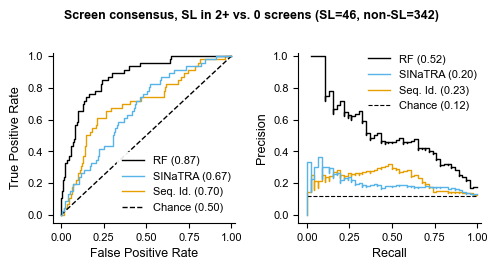

In [51]:
test_pairs = pd.merge(sinatra_preds, consensus_pairs)
print('Screen consensus pairs w/ SINaTRA predictions:', test_pairs.shape[0], '/', consensus_pairs.shape[0])
ypred = RF.predict_proba(test_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.1,2.6))
draw_curves(test_pairs, ypred, test_pairs['SINaTRA_Score'], ax, 'Screen consensus, SL in 2+ vs. 0 screens', 'SINaTRA ')
plt.tight_layout()
ax[1].legend(loc='upper right', bbox_to_anchor=(1.05,1.05), fontsize=8)
f.savefig("../figures/for_paper/sinatra_metrics_2+.svg", dpi=300, bbox_inches="tight")

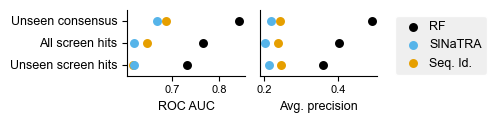

In [32]:
res_roc, res_pr = compute_metrics_for(sinatra_preds, score_col='SINaTRA_Score', label='SINaTRA')
f, ax = plt.subplots(1,2, figsize=(5.1,1.3), sharey=True)
draw_metrics_dot_plot(ax, res_roc, res_pr)

### SLANT

In [34]:
slant_preds = pd.read_csv(file_slant_full, sep=' ')

In [44]:
print('N pairs:', slant_preds.shape[0])
slant_paralog_preds = pd.merge(slant_preds.rename(columns={'gene1':'A2_ensembl','gene2':'A1_ensembl'}), all_pairs)
slant_paralog_preds = slant_paralog_preds[['sorted_gene_pair','consensus']].drop_duplicates()
print('N paralog pairs: %d = %.3f%%' % (slant_paralog_preds.shape[0], slant_paralog_preds.shape[0]/(all_pairs.shape[0]/2)*100))
slant_paralog_preds[:1]

N pairs: 6455807
N paralog pairs: 3385 = 9.237%


,sorted_gene_pair,consensus
0,EZR_MYLIP,0.629569


Screen consensus pairs w/ SLant predictions: 141 / 457


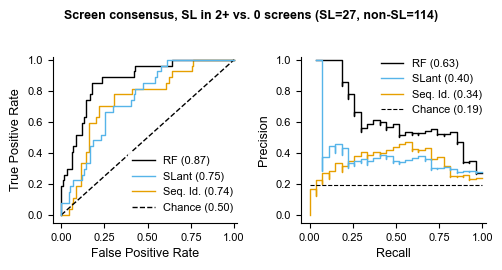

In [38]:
# Distinguishing pairs SL in 2+ vs. 0 screens
test_pairs = pd.merge(slant_paralog_preds, consensus_pairs)
print('Screen consensus pairs w/ SLant predictions:', test_pairs.shape[0], '/', consensus_pairs.shape[0])
ypred = RF.predict_proba(test_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.1,2.6))
draw_curves(test_pairs, ypred, test_pairs['consensus'], ax, 'Screen consensus, SL in 2+ vs. 0 screens', 'SLant ')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.05,1.05), fontsize=8)
plt.tight_layout()
f.savefig("../figures/for_paper/slant_metrics_2+.svg", dpi=300, bbox_inches="tight")

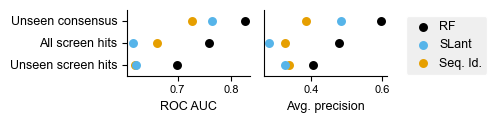

In [39]:
res_roc, res_pr = compute_metrics_for(slant_paralog_preds, score_col='consensus', label='SLant')
f, ax = plt.subplots(1,2, figsize=(5.1,1.3), sharey=True)
draw_metrics_dot_plot(ax, res_roc, res_pr)

### Dual-DropoutGCN (Cai et al. 2020)

In [40]:
cai_pred_raw = pd.read_csv(file_cai_pred)

In [41]:
print('N gene pairs:', cai_pred_raw.shape[0])
cai_pred_raw[:1]

N gene pairs: 20297457


,Rank,Gene 1,Gene 1 Degree,Gene 2,Gene 2 Degree,Predicted likelihood
0,1,HRAS,1458.0,NRAS,1457.0,1.0


In [50]:
# Check assumption that only predictions for pairs with genes in training data can be made
cai_training = pd.read_csv(file_cai_training, sep='\t', names=['gene1','gene2','score'])
cai_training_genes = pd.concat([cai_training.gene1, cai_training.gene2]).drop_duplicates()
print('Cai et al. preds for pairs with genes not in training data:',
      cai_pred_raw[(~cai_pred_raw['Gene 1'].isin(cai_training_genes)) | 
                   (~cai_pred_raw['Gene 2'].isin(cai_training_genes))].shape[0])

Cai et al. preds for pairs with genes not in training data: 0


In [43]:
cai_preds = pd.merge(cai_pred_raw.rename(columns={'Gene 1':'A1', 'Gene 2':'A2'}), all_pairs[['A1','A2','sorted_gene_pair']])
cai_preds = cai_preds[['sorted_gene_pair','Predicted likelihood']].drop_duplicates()
print('N paralog pairs: %d = %.3f%%' % (cai_preds.shape[0], cai_preds.shape[0]/(all_pairs.shape[0]/2)*100))
cai_preds[:1]

N paralog pairs: 3672 = 10.020%


,sorted_gene_pair,Predicted likelihood
0,HRAS_NRAS,1.0


Screen consensus pairs w/ Cai et al. predictions: 98 / 457


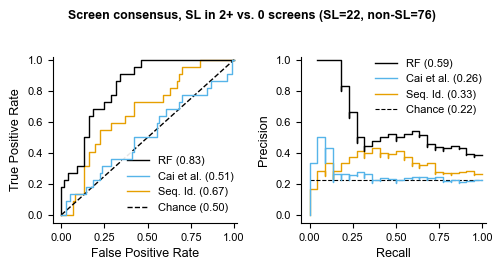

In [52]:
test_pairs = pd.merge(cai_preds, consensus_pairs)
print('Screen consensus pairs w/ Cai et al. predictions:', test_pairs.shape[0], '/', consensus_pairs.shape[0])
ypred = RF.predict_proba(test_pairs[features])[:,1]

f, ax = plt.subplots(1, 2, figsize=(5.1,2.6))
draw_curves(test_pairs, ypred, test_pairs['Predicted likelihood'], ax,'Screen consensus, SL in 2+ vs. 0 screens','Cai et al. ')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.05,1.05), fontsize=8)
plt.tight_layout()
f.savefig("../figures/for_paper/cai_metrics_2+.svg", dpi=300, bbox_inches="tight")

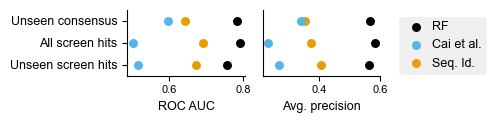

In [53]:
res_roc, res_pr = compute_metrics_for(cai_preds, score_col='Predicted likelihood', label='Cai et al.')
f, ax = plt.subplots(1,2, figsize=(5.1,1.3), sharey=True)
draw_metrics_dot_plot(ax, res_roc, res_pr)

### Summary stats for all classifiers (Table S7)

In [54]:
test_datasets = [consensus_pairs, all_screened_pairs, unseen_consensus_pairs, unseen_screened_pairs]
test_dataset_labels = ["Screen consensus", "All screen hits", "Unseen screen consensus", "Unseen screen hits"]

df = pd.DataFrame(columns=["Other_classifier","Test dataset", "n_SL", "n_non_SL",
                           "RF_ROC_AUC", "Other_ROC_AUC", "Seq_id_ROC_AUC", "RF_AP", "Other_AP", "Seq_id_AP"])

other_classifier_preds = sinatra_preds, slant_paralog_preds, cai_preds
other_classifier_labels = ['SINaTRA', 'SLant', 'Cai et al.']
score_cols = ['SINaTRA_Score', 'consensus', 'Predicted likelihood']

for i, classifier_preds in enumerate(other_classifier_preds):
    for j, test_data in enumerate(test_datasets):
        test_pairs = pd.merge(classifier_preds, test_data)
        ypred = RF.predict_proba(test_pairs[features])[:,1]
        score_col=score_cols[i]
        df.loc[(i*4)+j] = [other_classifier_labels[i], test_dataset_labels[j],
                           sum(test_pairs.SL), sum(test_pairs.SL==False),
                           roc_auc_score(test_pairs.SL, ypred),
                           roc_auc_score(test_pairs.SL, test_pairs[score_col]),
                           roc_auc_score(test_pairs.SL, test_pairs.min_sequence_identity),
                           average_precision_score(test_pairs.SL, ypred),
                           average_precision_score(test_pairs.SL, test_pairs[score_col]),
                           average_precision_score(test_pairs.SL, test_pairs.min_sequence_identity)]
df = df.round(decimals=2)

In [55]:
df

,Other_classifier,Test dataset,n_SL,n_non_SL,RF_ROC_AUC,Other_ROC_AUC,Seq_id_ROC_AUC,RF_AP,Other_AP,Seq_id_AP
0,SINaTRA,Screen consensus,46,342,0.87,0.67,0.70,0.52,0.20,0.23
1,SINaTRA,All screen hits,202,1204,0.77,0.62,0.65,0.40,0.20,0.24
2,SINaTRA,Unseen screen consensus,35,229,0.84,0.67,0.69,0.49,0.22,0.24
3,SINaTRA,Unseen screen hits,167,876,0.73,0.62,0.62,0.36,0.22,0.25
4,SLant,Screen consensus,27,114,0.87,0.75,0.74,0.63,0.40,0.34
5,SLant,All screen hits,96,347,0.76,0.62,0.66,0.48,0.28,0.33
6,SLant,Unseen screen consensus,20,72,0.83,0.76,0.73,0.60,0.48,0.39
7,SLant,Unseen screen hits,76,236,0.70,0.62,0.62,0.41,0.33,0.34
8,Cai et al.,Screen consensus,22,76,0.83,0.51,0.67,0.59,0.26,0.33
9,Cai et al.,All screen hits,70,229,0.79,0.50,0.69,0.58,0.23,0.37


In [56]:
df.to_excel(file_table_s7, index=0)